In [208]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np


In [250]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# Load and preprocess data
df = pd.read_csv("Dataset_timeseries.csv")
data = df.groupby("Number")
split = {g: d for g, d in data}
dataset = split[1].iloc[:, 1:]

sc = MinMaxScaler(feature_range=(-1, 1))

sequence_length = 10
sequences = []
for i in range(len(dataset['SOPAS']) - sequence_length):
    sequences.append(dataset['SOPAS'][i:i+sequence_length])

sequences = np.array(sequences)
# sequences = np.expand_dims(sequences, -1)
#sequences = dataset['SOPAS'].values.reshape(-1, 1)


In [251]:
print(sequences.shape)

(20634, 10)


In [252]:

# Isolation Forest for outlier detection
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(sequences)

# Predict outliers
predictions = model.predict(sequences)
outliers = np.where(predictions == -1)
outlier_data = sequences[outliers]
un_transformed=outlier_data
outlier_data = sc.fit_transform(outlier_data)
normal_data = sequences[np.where(predictions == 1)]
print(len(normal_data))

19602


In [253]:
outlier_data.shape

(1032, 10)

In [279]:
# Define GAN components
def build_generator(noise_dim):
    model = Sequential()
    
    model.add(Dense(256, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())
    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization())

    
    model.add(Dense(10, activation='tanh')) 
    return model


In [280]:
def build_discriminator():
    model = Sequential()
    model.add(Dense(256, input_dim=10))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
    
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.4))
   
    
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Initialize models
noise_dim = 200
generator = build_generator(noise_dim)
discriminator = build_discriminator()

In [282]:
discriminator.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_214 (Dense)           (None, 256)               2816      
                                                                 
 leaky_re_lu_76 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_132 (Dropout)       (None, 256)               0         
                                                                 
 dense_215 (Dense)           (None, 512)               131584    
                                                                 
 leaky_re_lu_77 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_133 (Dropout)       (None, 512)               0         
                                                                 
 dense_216 (Dense)           (None, 1024)            

In [ ]:
# Compile models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.02, beta_1=0.5), metrics=['accuracy'])
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.02, beta_1=0.5))





@tf.function
def train_step(real_samples):
    batch_size = real_samples.shape[0]

    # Generate fake samples
    noise = tf.random.normal([batch_size, noise_dim])
    generated_samples = generator(noise, training=True)

    # Real and fake labels
    real_labels = tf.ones((batch_size, 1))
    fake_labels = tf.zeros((batch_size, 1))

    # Train discriminator
    with tf.GradientTape() as tape:
        d_loss_real = discriminator(real_samples, training=True)
        d_loss_fake = discriminator(generated_samples, training=True)
        d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, d_loss_real))
        d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(fake_labels, d_loss_fake))
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
    
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    if grads and any(g is not None for g in grads):
        grads_and_vars = [(g, v) for g, v in zip(grads, discriminator.trainable_variables) if g is not None]
        discriminator.optimizer.apply_gradients(grads_and_vars)

    # Train generator
    with tf.GradientTape() as tape:
        noise = tf.random.normal([batch_size, noise_dim])
        generated_samples = generator(noise, training=True)
        g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(real_labels, discriminator(generated_samples, training=True)))
        grads = tape.gradient(g_loss, generator.trainable_variables)
    if grads and any(g is not None for g in grads):
        grads_and_vars = [(g, v) for g, v in zip(grads, generator.trainable_variables) if g is not None]
        gan.optimizer.apply_gradients(grads_and_vars)

    return d_loss, g_loss

def train_gan(epochs, batch_size, data):
    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], batch_size)
        real_samples = data[idx]

        d_loss, g_loss = train_step(real_samples)

      
        if epoch % 100 == 0:
            print(f"{epoch}: Discriminator Loss: {d_loss.numpy()}, Generator Loss: {g_loss.numpy()}")


data = outlier_data

# Train the GAN
train_gan(epochs=5000, batch_size=256, data=data)
    

In [260]:
noise = np.random.normal(0, 1, size=(1028,noise_dim))
generated_samples = generator.predict(noise)
generated_samples = sc.inverse_transform(generated_samples)
real_mean = np.mean(un_transformed)
real_std = np.std(un_transformed)
generated_mean = np.mean(generated_samples)
generated_std = np.std(generated_samples)

print(f"Real Data - Mean: {real_mean}, Std: {real_std}")
print(f"Generated Data - Mean: {generated_mean}, Std: {generated_std}")

33/33 [==============================] - 0s 2ms/step
Real Data - Mean: 1.4986915155906642, Std: 0.9585382234958385
Generated Data - Mean: 1.559913992881775, Std: 1.5445119142532349


In [261]:
print(generated_samples.shape)

(1028, 10)


In [262]:
noise = np.random.normal(0, 1, size=(15333,noise_dim))
generator.save("generator.h5")

generated_samples = generator.predict(noise)
generated_samples = sc.inverse_transform(generated_samples)
real_mean = np.mean(un_transformed)
real_std = np.std(un_transformed)
generated_mean = np.mean(generated_samples)
generated_std = np.std(generated_samples)

print(f"Real Data - Mean: {real_mean}, Std: {real_std}")
print(f"Generated Data - Mean: {generated_mean}, Std: {generated_std}")



480/480 [==============================] - 1s 2ms/step
Real Data - Mean: 1.4986915155906642, Std: 0.9585382234958385
Generated Data - Mean: 1.5601146221160889, Std: 1.5445125102996826


C:\Users\Nemro Neno\AppData\Local\Temp\ipykernel_6400\2745623859.py:15: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(generated_data, label='Generated Data', color='yellow', fill=False, alpha=0.3)


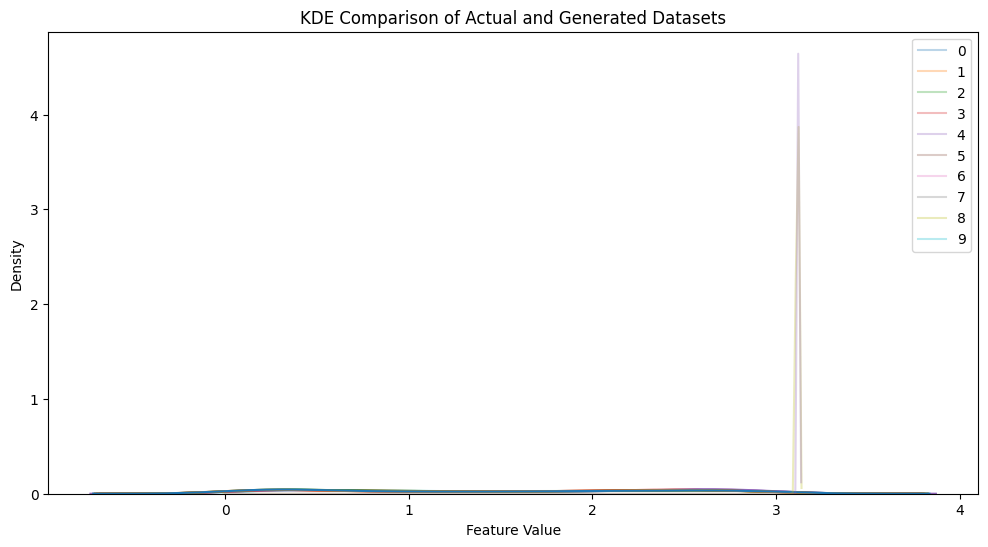

In [263]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example datasets (replace these with your actual datasets)
actual_data = un_transformed
generated_data = generated_samples
# Create a KDE plot
plt.figure(figsize=(12, 6))

# Plot KDE for the actual dataset
sns.kdeplot(actual_data, label='Actual Data', color='blue', fill=False, alpha=1)

# Plot KDE for the generated dataset
sns.kdeplot(generated_data, label='Generated Data', color='yellow', fill=False, alpha=0.3)

# Add labels and title
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.title('KDE Comparison of Actual and Generated Datasets')


# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Example data: single feature point

# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(range(len(generated_samples)), generated_samples, c='blue', marker='o', edgecolor='white', zorder=5)
plt.scatter(range(len(sequences)), sequences, c='red', marker='o', edgecolor='black')

# Add title and labels
plt.title("Single Feature Points")
plt.xlabel("Index")
plt.ylabel("Feature Value")

# Display the plot
plt.show()


In [264]:
iso_forest = IsolationForest(contamination=0.002, random_state=42)
iso_forest.fit(generated_samples)


predictions = iso_forest.predict(generated_samples)
outliers = np.where(predictions == 1)
true_val = np.where(predictions == -1)
actual_noise = generated_samples[outliers]
outlier_data = generated_samples[true_val]
print(len(actual_noise))


15329


In [265]:
# actual_noise=pd.DataFrame(generated_samples,columns=["SOPAS"])
# actual_noise['Number']=0
# normal_data=pd.DataFrame(sequences,columns=["SOPAS"])
# normal_data['Number']=1
# final_dataset=pd.concat([normal_data,actual_noise],ignore_index=True)
# # Shuffle the combined dataframe
# final_dataset.to_csv('final_dataset.csv')
# print(final_dataset)

x=np.concatenate((sequences,generated_samples),axis=0)
y=np.concatenate((np.ones(sequences.shape[0]),np.zeros(generated_samples.shape[0])),axis=0) 
x=x[:-947]
y=y[:-947]
print(x.shape)
print(y.shape)


(35020, 10)
(35020,)


In [239]:
print(y)

[1. 1. 1. ... 0. 0. 0.]


In [266]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config


In [267]:
class PositionalEncoding(layers.Layer):
    def __init__(self, embed_dim,**kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.embed_dim = embed_dim

    def call(self, x):
        # Get the shape of the input tensor
        seq_length = tf.shape(x)[-2]
        
        # Generate position indices and cast to float32
        position = tf.range(start=0, limit=seq_length, delta=1, dtype=tf.float32)
        position = tf.expand_dims(position, axis=1)

        # Calculate the angle rates
        angle_rates = 1 / tf.pow(tf.cast(10000, tf.float32), tf.cast((2 * (tf.range(tf.cast(self.embed_dim, tf.float32)) // 2)) / tf.cast(self.embed_dim, tf.float32),tf.float32))
        
        # Compute the angle radians
        angle_rads = tf.matmul(position, tf.expand_dims(angle_rates, 0))

        # Apply sin and cos to alternate positions
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        
        # Concatenate sines and cosines to create the positional encoding
        pos_encoding = tf.concat([sines, cosines], axis=-1)

        # Expand the positional encoding to match the batch size
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)
        
        # Add positional encoding to input tensor
        return x + pos_encoding
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
        })
        return config


In [268]:
def build_transformer_model(input_shape, embed_dim=4, num_heads=1, ff_dim=4):
    inputs = layers.Input(shape=input_shape)

    # Embedding and Positional Encoding (if applicable)
    x = layers.Dense(embed_dim)(inputs)
    x = PositionalEncoding(embed_dim)(x)

    # Transformer block
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)

    # Pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [269]:
model = build_transformer_model(input_shape=(1,10))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1, 10)]           0         
                                                                 
 dense_192 (Dense)           (None, 1, 4)              44        
                                                                 
 positional_encoding_22 (Pos  (None, 1, 4)             0         
 itionalEncoding)                                                
                                                                 
 transformer_block_22 (Trans  (None, 1, 4)             136       
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_22  (None, 4)                0         
  (GlobalAveragePooling1D)                                       
                                                          

In [270]:
import pandas as pd
from sklearn.model_selection import train_test_split
x=x.reshape(-1,1,10)
indx=np.arange(len(x))
np.random.shuffle(indx)
x_shuf=x[indx]
y_shuf=y[indx]
x_train,x_test,y_train,y_test=train_test_split(x_shuf,y_shuf,test_size=0.4,random_state=42)



In [271]:
model.fit(x_train, y_train, epochs=5, batch_size=256, validation_split=0.4)

Epoch 1/5
50/50 [==============================] - 2s 26ms/step - loss: 0.4002 - accuracy: 0.9142 - val_loss: 0.2456 - val_accuracy: 0.9974
Epoch 2/5
50/50 [==============================] - 1s 15ms/step - loss: 0.1974 - accuracy: 0.9860 - val_loss: 0.1131 - val_accuracy: 0.9995
Epoch 3/5
50/50 [==============================] - 1s 16ms/step - loss: 0.1006 - accuracy: 0.9959 - val_loss: 0.0508 - val_accuracy: 0.9996
Epoch 4/5
50/50 [==============================] - 1s 17ms/step - loss: 0.0524 - accuracy: 0.9989 - val_loss: 0.0240 - val_accuracy: 0.9999
Epoch 5/5
50/50 [==============================] - 1s 18ms/step - loss: 0.0277 - accuracy: 0.9994 - val_loss: 0.0088 - val_accuracy: 1.0000


In [272]:
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)

438/438 [==============================] - 2s 5ms/step


Accuracy: 0.9999286122215877


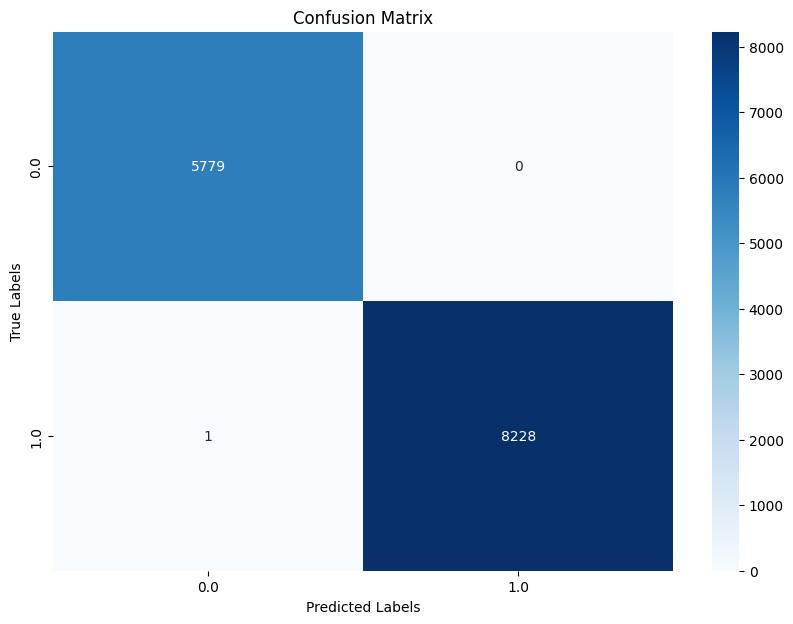

In [273]:
cm = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert the classification report dictionary to a DataFrame
import pandas as pd

# Extract class names
class_names = list(report_dict.keys())
class_names.remove('accuracy')  # Remove 'accuracy' from the class names list

# Create DataFrame from classification report
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.reset_index().rename(columns={'index': 'Class'})

# Save the classification report to a PDF
pdf_filename = 'classification_report.pdf'

In [274]:
with PdfPages(pdf_filename) as pdf:
    plt.figure(figsize=(12, 8))
    plt.table(cellText=report_df.values,
              colLabels=report_df.columns,
              rowLabels=report_df['Class'],
              cellLoc='center',
              loc='center')
    plt.axis('off')
    plt.title(f'Classification Report\nAccuracy: {accuracy:.2f}')
    
    # Save the plot to the PDF
    pdf.savefig()
    plt.close()

print(f'Classification report saved to {pdf_filename}')

Classification report saved to classification_report.pdf


In [275]:
model.save('Transformerclassifier.h5')

In [276]:
loaded_model = tf.keras.models.load_model('Transformerclassifier.h5', 
                                          custom_objects={'TransformerBlock': TransformerBlock, 
                                                          'PositionalEncoding': PositionalEncoding})

In [277]:
loaded_model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1, 10)]           0         
                                                                 
 dense_192 (Dense)           (None, 1, 4)              44        
                                                                 
 positional_encoding_22 (Pos  (None, 1, 4)             0         
 itionalEncoding)                                                
                                                                 
 transformer_block_22 (Trans  (None, 1, 4)             136       
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_22  (None, 4)                0         
  (GlobalAveragePooling1D)                                       
                                                          